# Problem 1

**Capacitated facility location**

You need to solve a *capacitated facility location* problem. There are a number of clients that can be served by a number of potential facilities. As in the case of a common (uncapacitated) facility location problem, you need to decide which facilities to open (paying the opening cost for each) and which clients to serve at each facility (paying the assignment cost). Each client must be assigned to one opened facility. In addition, you have a cap on how many clients each facility can serve. As usual, you want to minimize the costs.

Implement the following algorithms and investigate them. Use the below code to generate the data, and to visualize the results. You are supposed to play with different configurations and problem sizes. Please make your report detailed (otherwise lower amount of points than indicated may be assigned).

* (2 points). Implement a **greedy algorithm** for the problem.
* (3 points). Implement **some local optimization algorithm**. Try to design powerful moves that are at the same time easy to search through. **Important:** your move should connect the whole domain, i.e. for any pair of feasible solutions, there should exist a sequence of moves from the family you design that transform one solution to the other.
* (3 points). Implement the **simulated annealing algorithm** based on the best of your local optimization algorithms. Play with the schedule and see how it affects the results. Compare with the local optimization algorithm that you base upon. Note, that if implemented correctly, simulated annealing should improve over the local optimization algorithm.

Below is the Gurobi solution that uses a mixed-integer solver (we will come to that in week 3). You can use it as a reference for small instances (for which it will give you a global optimum), and also reuse the visualization code.

Before writing your code, study the cells below to learn variables, convention for the solution format etc.

In [2]:
import numpy as np
import scipy as sp
from numpy import random
from numpy import matlib
import matplotlib.pyplot as plt
from gurobipy import GRB
import gurobipy as grb

%matplotlib inline

class Problem:
    def __init__(self, C=20, F=15):
        self.C = C
        self.F = F
        
        self.clients = np.random.rand(2, C)    # client positions
        self.facilities = np.random.rand(2, F) # facility positions

        # maximum number of clients per facility
        self.capacities = np.ones((F,), dtype=np.int32)*4;

        # assignment cost is defined as the squared distance between a client and a facility
        dx = \
            np.matlib.repmat(self.clients[0,:],F,1) - \
            np.matlib.repmat(self.facilities[0,:],C,1).transpose();
        dy = \
            np.matlib.repmat(self.clients[1,:],F,1) - \
            np.matlib.repmat(self.facilities[1,:],C,1).transpose();

        self.assignment_costs = 3*(dx*dx + dy*dy);

        self.opening_costs = np.ones((F,));
    
    def assign_random_capacities(self):
        """
        Assign more or less random capacities to facilities.
        
        This is one of the possible ways to change the problem configuration.
        In other words, use this function when testing your solution!
        """
        while True:
            self.capacities = \
                np.random.randint(2*self.C // self.F, size=self.F) + 1
            if sum(self.capacities) > self.C * 1.3:
                break
    
    def assign_random_opening_costs(self):
        """
        Assign more or less random opening costs to facilities.
        
        Same as above -- use this for your report.
        """
        # could be float, but let it be simple
        self.opening_costs = \
            np.random.randint((self.C+self.F-1) // self.F, size=self.F) + 1
    
    def plot(self, y, assignments, fig=plt):
        """
        Plot the given solution (y, assignments)
        
        Arguments:
        y, assignments -- see Problem.objective().
        fig            -- an instance of matplotlib.axes._axes.Axes to draw on.
                          Also, can be matplotlib.pyplot, in this case use the default Axes.
                          This is useful to compare your results (see "Results comparison" section).
        """
        
        y = np.array(y, dtype='int32')
        assignments = np.array(assignments, dtype='int32')
        
        for cli,fac in enumerate(assignments):
            fig.plot([self.clients[0,cli], self.facilities[0,fac]], \
                     [self.clients[1,cli], self.facilities[1,fac]], c=(.7,.7,.7))
            
        fig.scatter(self.clients[0,:], self.clients[1,:], s=15.0, c=assignments, \
                    vmin=0, vmax=self.F-1)
        
        fig.scatter(self.facilities[0,:], self.facilities[1,:], s=54.0, \
                    c=range(self.F), linewidth = [1*el for el in y], marker=',')
        
    def objective(self, y, assignments):
        """
        Return objective function value given a solution.
        If the solution is infeasible, return infinity.
        
        Arguments:
        y           -- a binary 1D array of size F. y[i] is 1 iff i-th facility is open.
        assignments -- an integer 1D array of size C. assignments[i] is index of facility
                       that i-th client is assigned to.
        """
        assert len(y) == self.F
        assert len(assignments) == self.C
        
        #y = np.array(y, dtype='int32')
        #assignments = np.array(assignments, dtype='int32')
        print(assignments)
        retval = sum(is_opened*opening_cost \
                     for is_opened, opening_cost in zip(y, self.opening_costs))
        
        assignment_counts = np.zeros_like(y)
        
        for cli,fac in enumerate(assignments):
            if not y[fac]:
                return np.inf
            else:
                retval += self.assignment_costs[fac,cli]
                assignment_counts[fac] += 1
                
        if any(assignment_counts > self.capacities):
            return np.inf
            
        return retval
        
    def solve_gurobi(self, verbose=False):
        """
        Solve the problem using mixed integer program solver.
        Return `y, assignments` (see Problem.objective() docstring for format).
        
        Arguments:
        verbose -- controls Gurobi output.
        """
        m = grb.Model("facility")

        y = []
        for i_f in range(self.F):
            y.append(m.addVar(vtype=GRB.BINARY))

        x = []    
        for i_f in range(self.F):
            x.append([])
            for i_c in range(self.C):
                x[i_f].append(m.addVar(vtype=GRB.BINARY))

        # the objective is to minimize the total fixed and variable costs
        m.modelSense = GRB.MINIMIZE

        # update model to integrate new variables
        m.update()

        # set optimization objective - minimize sum of fixed costs
        obj_summands = []
        for i_f in range(self.F):
            obj_summands.append(self.opening_costs[i_f]*y[i_f])

        for i_f in range(self.F):
            for i_c in range(self.C):
                obj_summands.append(self.assignment_costs[i_f][i_c]*x[i_f][i_c])

        m.setObjective(grb.quicksum(obj_summands))

        # set constraints
        for i_c in range(self.C):
            client_constr_summands = [x[i_f][i_c] for i_f in range(self.F)]
            m.addConstr(sum(client_constr_summands), GRB.EQUAL, 1.0)

        for i_f in range(self.F):        
            facility_constr_summands = [x[i_f][i_c] for i_c in range(self.C)]
            m.addConstr(sum(facility_constr_summands), \
                        GRB.LESS_EQUAL, self.capacities[i_f]*y[i_f])       

        for i_f in range(self.F):        
            for i_c in range(self.C):
                m.addConstr(x[i_f][i_c], GRB.LESS_EQUAL, y[i_f])

        # optimize
        m.setParam(GRB.Param.OutputFlag, verbose)
        m.optimize()
        
        facilities_opened = [np.int(y[i_f].X) for i_f in range(self.F)]
        clients_assignment = \
            [i_f for i_c in range(self.C) for i_f in range(self.F) if x[i_f][i_c].X != 0]
        print("GRBOUT ",clients_assignment)
        print("GRBOUT ",facilities_opened)
        return facilities_opened, clients_assignment

The following example shows `Problem` class usage.

[  4.  11.  10.  12.   6.  14.   5.   0.   7.   9.   3.   2.   4.  11.  10.
  12.   6.  14.   5.   0.]
GRBOUT  [14, 8, 10, 14, 7, 0, 10, 11, 2, 12, 1, 6, 1, 8, 12, 6, 5, 11, 0, 5]
GRBOUT  [1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1]
[14, 8, 10, 14, 7, 0, 10, 11, 2, 12, 1, 6, 1, 8, 12, 6, 5, 11, 0, 5]


D:\Programs\Anaconda\lib\site-packages\ipykernel\__main__.py:93: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
D:\Programs\Anaconda\lib\site-packages\ipykernel\__main__.py:96: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
D:\Programs\Anaconda\lib\site-packages\ipykernel\__main__.py:97: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


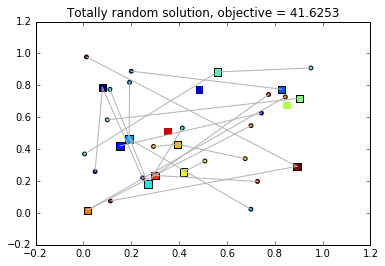

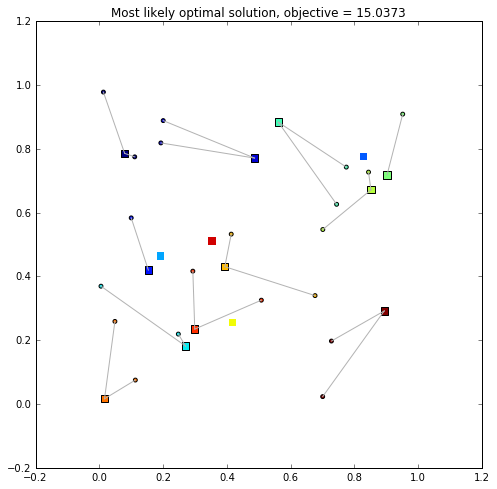

In [19]:
# to make results reproducible, be sure to put this line before creating a Problem()
np.random.seed(666)

problem = Problem()
problem.assign_random_capacities()
problem.assign_random_opening_costs()

# completely random solution
open_idx = list(range(problem.F))
random.shuffle(open_idx)
open_idx = open_idx[:problem.F * 4 // 5] # open 80% of facilities

y = np.zeros(problem.F)
y[open_idx] = 1

from itertools import cycle
assignments = np.empty(problem.C)
for cli, fac in zip(range(problem.C), cycle(open_idx)):
    assignments[cli] = fac

ax = plt.figure().gca()
problem.plot(y, assignments, ax)
ax.set_title('Totally random solution, objective = %.4f' % problem.objective(y, assignments))

ax = plt.figure(figsize=(8,8)).gca()
y, assignments = problem.solve_gurobi()
problem.plot(y, assignments, ax)
ax.set_title('Most likely optimal solution, objective = %.4f' % problem.objective(y, assignments))

## Greedy algorithm

### Defining the solution

First we need to define the solution.

In [27]:
class Facility:
    def __init__(self,loc,opCost,cpcty,Id):
        self.id=Id
        self.location=loc
        self.openingCost=opCost
        self.capacity=cpcty
        
class Client:
    def __init__(self,loc,assignTo=-1):
        self.location=loc
        self.assignment=assignTo
        
class Solution:
    def __init__(self,faclts=np.array([],dtype='object'),clnts=np.array([],dtype='object')):
        self.clients=clnts
        self.facilities=faclts
        self.cost=-1
        self.feasible=False
        
    def ComputeCost(self):
        if(len(self.clients)==0 or len(self.facilities)==0 or np.any([cl.assignment==-1 for cl in self.clients])):
            self.cost=-1
        else:
            self.cost=0
            ids=set([])
            for cl in self.clients:
                if(cl.assignment.id not in ids):
                    ids.add(cl.assignment.id)
                    self.cost=self.cost+cl.assignment.openingCost
                
            self.cost= self.cost + np.sum([np.linalg.norm(cl.location-cl.assignment.location,2)**2 for cl in self.clients])
        return self.cost
    
    def CheckFeasibility(self):
        #each client is assigned to exactly one facility
        if(np.all([not(cl.assignment==-1) for cl in self.clients])):
            #each facility does not exceed its capacity
            if(np.all([np.sum([int(cl.assignment==fac) for cl in self.clients])<=fac.capacity for fac in self.facilities])):
                self.feasible=True
                return True
            else:
                self.feasible=False
                return False
        else:
            self.feasible=False
            return False
        
    def AssignNearestFacilities(self):
        capacitiesLeft=np.array([fac.capacity for fac in self.facilities])
        for cl in self.clients:
            availableFacs=np.arange(len(self.facilities))[capacitiesLeft>0]
            #print(len(availableFacs))
            #print(len(self.facilities))
            k=np.argmin([np.linalg.norm(cl.location-fac.location,2) for fac in self.facilities[availableFacs]])
            k=availableFacs[k]
            cl.assignment=self.facilities[k]
            capacitiesLeft[k]=capacitiesLeft[k]-1
                
        

Firstly, we can obtain a lower bound for cost by assigning clients to closest facility. Indeed, if some capacity contraints are violated in this case, one needs to swap clients between facilities and increase total distance.

In [23]:
def NNLowerBound(sol):
    cost=0
    for cl in sol.clients:
        cost=cost+np.min(np.array([np.linalg.norm(cl.location-fac.location,2)**2 for fac in sol.facilities]))

    return cost
        

Secondly, we are able to easily detect infeasibility by comparing total capacity and number of clients.

In [24]:
def CheckEarlyFeasibility(sol):
    cap=np.sum([fac.capacity for fac in sol.facilities])
    if(cap>=len(sol.clients)):
        return True
    else:
        return False

I have implemented the nearest facility heuristic with capacity constraints to assign clients to facilities in a Branch-and-Bound manner. NNLowerBound was used as a lower bound and we try to enumerate all possible facility openings.

In [25]:
def solve_greedy(self):
    y = np.zeros(self.F, dtype=np.int32)
    assignments = np.empty(self.C, dtype=np.int32)
    
    # your code here
    print(self.facilities[:,0])
    facs0=np.array([Facility(self.facilities[:,i],self.opening_costs[i],self.capacities[i],i) for i in range(0,self.F)],dtype='object')
    cls0=np.array([Client(self.clients[:,i],-1) for i in range(0,self.C)],dtype='object')
    sol0 = Solution(facs0,cls0)
    
    
    opened=np.zeros(self.F,dtype='bool')
    k=0
    opt=np.Inf
    solOpt = None
    y=np.zeros(self.F,dtype='bool')
    while(k<2**self.F):
        k=k+1
        
        #+1 to boolean array
        j0=len(opened)-1
        while(j0>=0 and opened[j0]):
            opened[j0]=False
            j0=j0-1    
        if(j0>=0):
            opened[j0]=True
        
        assFacs=sol0.facilities[opened]
        sol=Solution(assFacs,np.copy(sol0.clients))
        if(CheckEarlyFeasibility(sol)):
            if(NNLowerBound(sol0)+np.sum([fac.openingCost for fac in assFacs])<opt):
                sol.AssignNearestFacilities()
                if(sol.ComputeCost()<opt):
                    opt=sol.cost
                    print("New optimal Cost!",opt)
                    y=np.copy(opened)
                    print(np.any([not(y[cl.assignment.id]) for cl in sol.clients]))
                    assignments=[cl.assignment.id for cl in sol.clients]
                    
    
    
    print(assignments)    
    y=np.array(y,dtype='int32')    
    print(y)
    
    return y, assignments

Problem.solve_greedy = solve_greedy


*(Demonstrate your greedy algorithm here)*

In [26]:
#problem = Problem()
#problem.assign_random_capacities()
#problem.assign_random_opening_costs()

y, assignments=problem.solve_greedy()

[ 0.07934213  0.78613657]


AttributeError: 'set' object has no attribute 'contains'

[14, 8, 14, 10, 7, 0, 10, 2, 0, 12, 1, 8, 1, 6, 12, 6, 5, 11, 5, 11]
[1 1 1 0 0 1 1 1 1 0 1 1 1 0 1]
[14, 8, 14, 10, 7, 0, 10, 2, 0, 12, 1, 8, 1, 6, 12, 6, 5, 11, 5, 11]


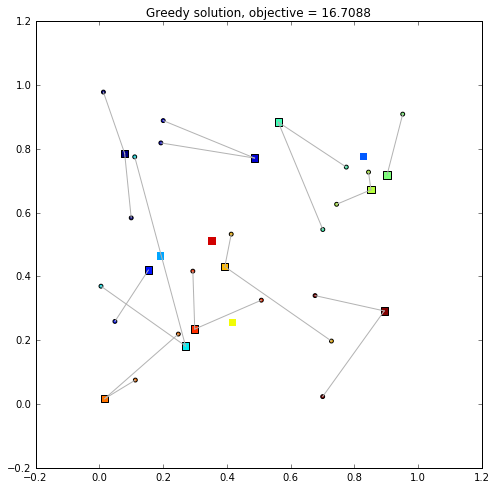

In [21]:
ax = plt.figure(figsize=(8,8)).gca()
problem.plot(y,assignments)
ax.set_title('Greedy solution, objective = %.4f' % problem.objective(y, assignments))
print(y)
print(assignments)

## Local optimization algorithm

We can use open/close(with re-assigning clients, if possible) warehouse, switch two clients and re-assign client as local moves. Obviously the domain is connected: we could obtain any feasible solution by adding or removing the warehouse and re-assigning clients. Since re-assigning is not really powerful change, I also have added swapping clients between warehouses.

We could start with nearest neighbour heuristic solution from above and try to improve it using the defined neighbourhood. It is seen on the charts that some client swaps can make a difference to cost.

*(Describe your local optimization algorithm here. Make sure that its moves cover the whole solution domain)*

In [11]:
def GenerateNeighbourhood(sol):
    #open a new warehouse
    neighbourhood=[]
    openedWh = set([])
    for cl in sol.clients:
        if(cl.assigned)
def solve_local_optimization(self):
    y, assignments = self.solve_greedy
    print(self.facilities[:,0])
    facs0=np.array([Facility(self.facilities[:,i],self.opening_costs[i],self.capacities[i],i) for i in range(0,self.F)],dtype='object')
    cls0=np.array([Client(self.clients[:,i],self.facilities[assignments[i]]) for i in range(0,self.C)],dtype='object')
    sol0 = Solution(facs0,cls0)#start solution obtained with greedy algorithm
    
    
    while(True):
        
    
    
    pass # your code here

Problem.solve_local_optimization = solve_local_optimization

*(Demonstrate your local optimization algorithm here)*

## Simulated annealing

In [ ]:
def solve_simulated_annealing(self, max_iter=10000, T_0=100, schedule='exp'):
    pass # your code here. You can add function parameters as needed.
    # You are expected to implement several temperature schedules

Problem.solve_simulated_annealing = solve_simulated_annealing

*(Demonstrate your simulated annealing algorithm here. Try different sets of parameters and determine the best one)*

## Results comparison

*(Compare 4 methods (with their best parameters) on different problems, capacities etc. Don't forget corner cases like $C \gg F$, $C = F$, $\dots$)*

In [ ]:
# Suggested code for comparison (modify as needed)

def compare_results(problem):
    fig = plt.figure()

    ax_greedy = fig.add_subplot(221)
    ax_local  = fig.add_subplot(222)
    ax_anneal = fig.add_subplot(223)
    ax_gurobi = fig.add_subplot(224)

    greedy = problem.solve_greedy()
    local  = problem.solve_local_opt()
    gurobi = problem.solve_gurobi()
    anneal = problem.solve_sim_annealing()

    ax_greedy.set_title('Greedy:    %.3f' % problem.objective(*greedy))
    ax_local .set_title('Local:     %.3f' % problem.objective(*local))
    ax_anneal.set_title('Annealing: %.3f' % problem.objective(*anneal))
    ax_gurobi.set_title('Gurobi:    %.3f' % problem.objective(*gurobi))

    problem.plot(greedy[0], greedy[1], ax_greedy)
    problem.plot(local [0], local [1], ax_local )
    problem.plot(anneal[0], anneal[1], ax_anneal)
    problem.plot(gurobi[0], gurobi[1], ax_gurobi)

    for ax in ax_greedy, ax_local, ax_anneal, ax_gurobi:
        ax.axes.get_xaxis().set_ticks([])
        ax.axes.get_yaxis().set_ticks([])

# Problem 2
**Optimal vehicle speed scheduling (6 points)** -- (based on an additional exercise A3.20 to Boyd and Vandenberghe). 

A vehicle (say, an airplane) travels along a fixed path of $n$ segments, between $n + 1$ waypoints labeled $0, \dots , n$. Segment $i$ starts at waypoint $i-1$ and terminates at waypoint $i$. The vehicle starts at time $t = 0$ at waypoint $0$. It travels over each segment at a constant (nonnegative) speed; $s_i$ is the speed on segment $i$. We have lower and upper limits on the speeds: $s_{\min} \leq s \leq s_{\max}$. The vehicle does not stop at the waypoints; it simply proceeds to the next segment. The travel distance of segment $i$ is $d_i$ (which is positive), so the travel time over segment $i$ is $\frac{d_i}{s_i}$. We let $\tau_i$, $i = 1, \dots, n$ denote the time at which the vehicle arrives at waypoint $i$. The vehicle is required to arrive at waypoint $i$, $i = 1, \dots, n$, between times $\tau_{\min,i}$ and $\tau_{\max,i}$, which are given. The vehicle consumes fuel over segment $i$ at a rate that depends on its speed $\Phi\left(s_i\right) = a s_i^2+b s_i+c$ kg/s.

You are given the data $d$ (segment travel distances), $s_{\min}$ and $s_{\max}$ (speed bounds), $\tau_{\min}$ and $\tau_{\max}$ (waypoint arrival time bounds), and parameters $a$, $b$, and $c$ (all parameters are in *veh_speed_sched_data.m*). Use the dynamic programming approach to find the schedule that allows spending the minimal amount of fuel. Use matplotlib command *step* to plot speed vs time for the optimal schedule. You will need to discretize some continuous variables, make sure you do it densely enough.

**NB**: later in the course we will get back to this problem and attack it with a different method.


In [ ]:
import scipy.io as sio

mat_contents = sio.loadmat('veh_sched_data.mat')

a = mat_contents['a'][0,0]
b = mat_contents['b'][0,0]
c = mat_contents['c'][0,0]
d = mat_contents['d'].squeeze()
n = mat_contents['n'][0,0]
smin = mat_contents['smin'].squeeze()
smax = mat_contents['smax'].squeeze()
tau_min = mat_contents['tau_min'].squeeze()
tau_max = mat_contents['tau_max'].squeeze()